# ウィルスの(実効)潜伏期間のシミュレーション (性選択による進化シミュレーション)

(Version 0.0.3)

まず、患者の行動(隔離など)により、「ウィルスの弱毒化」が起きうることを示したかった (参: \[cocolog:94891057\](2024年6月) or >>2024-08-09T09:02:59Z )。

強毒のものが隔離される(死亡する)ことで、感染性をもつが、毒性の弱いものが広がりやすくなるはずだ。…という信念である。

これを Grok3 さんに相談してまず SIR 的モデルを作ってもらった(↓)。

https://gist.github.com/JRF-2018/b190e53d792a921f6ca56fa5aebc2c9d

しかし、それは弱毒株と強毒株がすでにある状態のモデルでしかない。そうではなく、どれぐらい弱毒か強毒かが確率的に決まり、どれぐらい感染力があるも確率的に決まるとき、強毒なものほど隔離されるとすると、弱毒かつ感染力があるものが広がりやすいということを示したい。

これを示すため Grok3 さんと相談して次にエージント・シミュレーションつまり、ABM (Agent-Based Model) も作った(↓)。

https://gist.github.com/JRF-2018/42d292c92325bce1c515d229fe9486b5

これで弱毒化はあるということは示せたが、そこで問題となったのは感染性のある潜伏期間がやっかいであるということ。その短縮をどうやるのかが次の問題となった。

ここからが今回の本題である。

人体の発熱は、そういう潜伏期間を許さず自己隔離を促すためでもあるのではないか…つまり発症するということ自体がある種の適応で、周りの目が隔離を促せるよう「発症」の在り方を進化させてきたのではないか…と考えた。

だから病弱だけど(病気の症状がすぐに出るけど)、死なない者が、(性選択において)選択的に子孫を残してきたのではないか？ はしかとか天然痘とか症状が出やすい物はそうなのではないか？ 現代の人類の美観には反するけれども。

人類が「裸」なのは、病痕がわかりやすいよう、それが、病痕が、美的に選択されてきたからだろうか？…いや、まさか。

…とここまで考えて、Grok3 さんと語らって頼んだところ、やはり Grok3 さんはそれを確かめるための ABM プログラムを提案してくれた。正直これまでと違ってそれは少しだけバグがあったのだが、簡単に修正できて、適宜変更を加えたのが今回のメインのコードになる。

今回の Grok3 さんとの会話は↓から読めるようにしてある。

https://x.com/i/grok/share/NJu1QacUXGwWDbkxNkuznT695


## メイン・コード
読みにくいかもしれないが、シュッとプログラムを提示するので読んでいただきたい。性選択とウィルスの潜伏期間・毒性の関係をシミュレーションするコードは次のようになる。

病痕の評価でグループ(種族)を分けていること・異種族間では交配・コンタクトが起きにくくしているのが特徴。また、人の免疫応答も考慮した「実効潜伏期間」を減らすために潜伏期間中も感染・回復・死亡が起きうるというモデルになっているのも特徴だろう。感染が続かないことがないよう、回復後も再感染が多少あるようにもしている。

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 乱数シードの設定
np.random.seed(42)

# パラメータ設定
N_RUNS = 50   # 信頼区間生成のためのシミュレーションの繰り返し回数

N = 1000   # 人口
T = 400    # 期間
INITIAL_A_RATE = 0.5   # 病痕への評価パターン 'A':評価しない
                       # 'B': 評価する の初期割合
CONTACT_RATE = 5   # 平均コンタクト数 (ポワソン分布)
LATENT_PERIOD_MEAN = 5   # 潜伏期間の初期平均
LATENT_PERIOD_STD = 1.0   # 潜伏期間の初期分散
LATENT_MUTATION_WIDTH = 0.1   # 潜伏期間の進化的変化幅
B_HAIR_UNATTRACTIVE = True   # 病痕評価者は「体毛」に嫌うか？ True:嫌う
INTERRACIAL_CONTACT = 0.5   # 異種族間のコンタクト強度
INTERRACIAL_MATING = 0.5   # 異種族間の交配強度

BETA = 0.3   # ウィルスの感染力
VIRULENCE = 0.005 * 7   # ウィルスの毒性 (高いほど死にやすい)
RECOVERY_RATE = 0.1 / 1.2   # 回復力
RECOVERED_BETA = BETA * 0.1   # 回復者の再感染力
LATENT_BETA_MAG = 0.1   # 潜伏期間の感染力を決める係数
LATENT_BETA = BETA * LATENT_BETA_MAG   # 潜伏期間中の感染力
LATENT_VIRULENCE = VIRULENCE * 0.5   # 潜伏期間の毒性
LATENT_RECOVERY_RATE = RECOVERY_RATE * 0.5   # 潜伏期間の回復力
LATENT_RECOVERED_BETA = RECOVERED_BETA \
    * LATENT_BETA_MAG  # 潜伏期間の回復者の回復力

# エージェントクラス
class Agent:
    def __init__(self, id, initial_a_rate):
        self.id = id
        # S：感受性(未感染)、'E': 潜伏期間, I：発症、R：回復、D：死亡
        self.state = 'S'
        # 状態経過時間
        self.time_in_state = 0
        # 免疫応答速度
        self.immune_response_rate = np.random.normal(1.0, 0.8)
        # 体毛率
        self.hair_coverage = np.random.uniform(0, 1)
        # 病痕
        self.scar = False
        # 生存中
        self.alive = True
        # 病痕の評価グループ 'A': 評価しない 'B': 評価する
        self.scar_effect_group \
            = np.random.choice(['A', 'B'], p=[initial_a_rate,
                                              1 - initial_a_rate])
        # 潜伏期間
        self.latent_period = max(1, np.random.normal(LATENT_PERIOD_MEAN,
                                                     LATENT_PERIOD_STD))

    def get_attractiveness (self, scar_effect_group):
        base = 1.0
        if self.state == 'I':
            base *= 0.5
        if self.scar:
            if scar_effect_group == 'A':
                base *= 0.8
            else:
                base *= 1.2
        if B_HAIR_UNATTRACTIVE \
           and scar_effect_group == 'B' and self.hair_coverage > 0.5:
            base *= 0.9
        if self.scar_effect_group != scar_effect_group:
            base *= INTERRACIAL_MATING
        return max(0, base)

# シミュレーションクラス
class VirusSimulation:
    def __init__(self, initial_a_rate):
        self.agents = [Agent(i, initial_a_rate) for i in range(N)]
        self.infected = []
        self.susceptible = list(range(N))
        self.recovered = []
        self.dead = []

        # 統計用記録
        self.history = {'S': [], 'E': [], 'I': [], 'R': [], 'D': []}
        self.group_counts = {'A': [], 'B': []}
        self.latent_period_history = []
        self.immune_response_history = []
        self.hair_coverage_history = []
        self.latent_period_group_history = {'A': [], 'B': []}
        self.immune_response_group_history =  {'A': [], 'B': []}
        self.hair_coverage_group_history = {'A': [], 'B': []}

        initial_infected = np.random.choice(N, 20, replace=False)
        for i in initial_infected:
            self.agents[i].state = 'E'
            self.infected.append(i)
            self.susceptible.remove(i)

    def step(self):
        new_infections = []
        for agent in self.agents:
            if not agent.alive:
                continue
            agent.time_in_state += 1

            if agent.state == 'E':
                # 潜伏期間中に感染
                contacts = np.random.poisson(CONTACT_RATE)
                # コンタクト対象は self.susceptible + self.recovered。
                # ただし、病痕好みの種族を考慮。
                targets = [x for x in self.susceptible + self.recovered
                           if self.agents[x].scar_effect_group
                           == agent.scar_effect_group
                           or np.random.random() < INTERRACIAL_CONTACT]
                for _ in range(contacts):
                    if targets:
                        target = np.random.choice(targets)
                        beta = LATENT_BETA
                        if self.agents[target].state == 'R':
                            beta = LATENT_RECOVERED_BETA
                        if self.agents[target].state in ['S', 'R'] \
                           and np.random.random() < beta:
                            new_infections.append(target)
                            # 潜伏期間は進化する。
                            new_latent \
                                = max(1, agent.latent_period
                                      * np.random.uniform(
                                          1.0 - LATENT_MUTATION_WIDTH,
                                          1.0 + LATENT_MUTATION_WIDTH
                                      ))
                            self.agents[target].latent_period = new_latent
                # 潜伏期間終了判定
                if agent.time_in_state \
                   >= int(max(1, agent.latent_period
                              / agent.immune_response_rate)):
                    agent.state = 'I'
                    agent.time_in_state = 0

                # 潜伏期間中も回復と死亡あり
                if np.random.random() < LATENT_RECOVERY_RATE:
                    agent.state = 'R'
                    self.recovered.append(agent.id)
                    if agent.id in self.infected:
                        self.infected.remove(agent.id)
                elif np.random.random() < LATENT_VIRULENCE:
                    agent.state = 'D'
                    agent.alive = False
                    self.dead.append(agent.id)
                    if agent.id in self.infected:
                        self.infected.remove(agent.id)
            elif agent.state == 'I':
                # 発症後の回復と死亡。発症後の回復者には病痕。
                if np.random.random() < RECOVERY_RATE:
                    agent.state = 'R'
                    agent.scar = True
                    self.recovered.append(agent.id)
                    if agent.id in self.infected:
                        self.infected.remove(agent.id)
                elif np.random.random() < VIRULENCE:
                    agent.state = 'D'
                    agent.alive = False
                    self.dead.append(agent.id)
                    if agent.id in self.infected:
                        self.infected.remove(agent.id)

                # 体毛のない裸の者は病が目立ち、
                # 一定確率でコンタクトを避けられる。
                if agent.time_in_state >= 1:
                    detection_prob = 1 - agent.hair_coverage
                    if np.random.random() < detection_prob:
                        continue

                # 発症後の感染: 係数以外 'E' の場合と同じアルゴリズム。
                contacts = np.random.poisson(CONTACT_RATE)
                targets = [x for x in self.susceptible + self.recovered
                           if self.agents[x].scar_effect_group
                           == agent.scar_effect_group
                           or np.random.random() < INTERRACIAL_CONTACT]
                for _ in range(contacts):
                    if targets:
                        target = np.random.choice(targets)
                        beta = BETA
                        if self.agents[target].state == 'R':
                            beta = RECOVERED_BETA
                        if self.agents[target].state in ['S', 'R'] \
                           and np.random.random() < beta:
                            new_infections.append(target)
                            new_latent \
                                = max(1, agent.latent_period
                                      * np.random.uniform(
                                          1.0 - LATENT_MUTATION_WIDTH,
                                          1.0 + LATENT_MUTATION_WIDTH
                                      ))
                            self.agents[target].latent_period = new_latent

        for i in new_infections:
            if i in self.susceptible:
                self.agents[i].state = 'E'
                self.infected.append(i)
                self.susceptible.remove(i)
            if i in self.recovered:
                self.agents[i].state = 'E'
                self.infected.append(i)
                self.recovered.remove(i)

    # 交配
    # 女性 f は自己の美的グループで評価され、
    # 男性 m は f の美的グループで評価されてつがう。
    # ただし、Agent 自体に男女の差はないのでそこは厳密ではない。
    def reproduction(self):
        group_A = [a for a in self.agents
                     if a.scar_effect_group == 'A' if a.alive]
        group_B = [a for a in self.agents
                     if a.scar_effect_group == 'B' if a.alive]
        alives = group_A + group_B
        agents = []
        rest = []
        for f in ['A', 'B']:
            group = group_A if f == 'A' else group_B
            attractiveness_scores_f = [a.get_attractiveness(f)
                                       for a in group]
            attractiveness_scores_m = [a.get_attractiveness(f)
                                       for a in alives]
            if not attractiveness_scores_f:
                continue
            total_attractiveness_f = sum(attractiveness_scores_f)
            if total_attractiveness_f == 0:
                continue
            if not attractiveness_scores_m:
                continue
            total_attractiveness_m = sum(attractiveness_scores_m)
            if total_attractiveness_m == 0:
                continue
            probabilities_f = [s / total_attractiveness_f
                               for s in attractiveness_scores_f]
            probabilities_m = [s / total_attractiveness_m
                               for s in attractiveness_scores_m]
            M = N - len(alives) if len(alives) < N/2 else N/2
            new_agents = []
            for _ in range(math.ceil(M * len(group) / len(alives))):
                mother = np.random.choice(group, 1, p=probabilities_f)[0]
                trying = 0
                while True:
                    father = np.random.choice(alives, 1, p=probabilities_m)[0]
                    trying += 1
                    if mother != father or trying >= 100:
                        break
                parents = [mother, father]
                child = Agent(
                    0, initial_a_rate=parents[0].scar_effect_group == 'A'
                )
                child.immune_response_rate = np.mean(
                    [p.immune_response_rate for p in parents]
                )
                child.hair_coverage = np.mean(
                    [p.hair_coverage for p in parents]
                )
                child.scar_effect_group = np.random.choice(
                    [p.scar_effect_group for p in parents]
                )
                child.latent_period = max(
                    1, int(np.mean([p.latent_period for p in parents]))
                )
                new_agents.append(child)
            k = int(N * len(group) / len(alives)) - len(new_agents)
            agents += new_agents + group[:k]
            rest += group[k:]

        agents += list(np.random.choice(rest, N - len(agents),
                                        replace=False))
        self.agents = agents
        for i, a in enumerate(self.agents):
            a.id = i
        self.susceptible = [a.id for a in self.agents
                            if a.state == 'S']
        self.infected = [a.id for a in self.agents
                         if a.state in ['E', 'I']]
        self.recovered = [a.id for a in self.agents
                          if a.state == 'R']
        self.dead = [a.id for a in self.agents if not a.alive]

    def run(self):
        for t in range(T):
            self.step()
            if t % 50 == 0:
                self.reproduction()


            # 状態の記録
            counts = {'S': 0, 'E': 0, 'I': 0, 'R': 0, 'D': 0}
            group_counts = {'A': 0, 'B': 0}
            for agent in self.agents:
                if agent.alive:
                    counts[agent.state] += 1
                    group_counts[agent.scar_effect_group] += 1
                else:
                    counts['D'] += 1
            for state in counts:
                self.history[state].append(counts[state])
            for group in group_counts:
                self.group_counts[group].append(group_counts[group])

            # 平均値の記録
            latent_periods = [agent.latent_period
                              for agent in self.agents
                              if agent.alive and agent.state in ['E', 'I']]
            immune_responses = [agent.immune_response_rate
                                for agent in self.agents
                                if agent.alive]
            hair_coverages  = [agent.hair_coverage
                               for agent in self.agents
                               if agent.alive]
            self.latent_period_history.append(
                np.mean(latent_periods)
                if latent_periods else LATENT_PERIOD_MEAN
            )
            self.immune_response_history.append(
                np.mean(immune_responses) if immune_responses else 1.0
            )
            self.hair_coverage_history.append(
                np.mean(hair_coverages) if hair_coverages else 1.0
            )

            for g in ['A', 'B']:
                group = [a for a in self.agents
                         if a.alive and a.scar_effect_group == g]
                latent_periods = [a.latent_period
                                  for a in group if a.state in ['E', 'I']]
                immune_responses = [a.immune_response_rate for a in group]
                hair_coverages = [a.hair_coverage for a in group]
                self.latent_period_group_history[g].append(
                    np.mean(latent_periods)
                    if latent_periods else LATENT_PERIOD_MEAN
                )
                self.immune_response_group_history[g].append(
                    np.mean(immune_responses)
                    if immune_responses else 1.0
                )
                self.hair_coverage_group_history[g].append(
                    np.mean(hair_coverages)
                    if hair_coverages else 1.0
                )

    def plot(self):
        # SEIRDプロット
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        for state in self.history:
            plt.plot(self.history[state], label=state)
        plt.xlabel('Time')
        plt.ylabel('Number of Agents')
        plt.title('SEIRD Model with Sex Selection')
        plt.legend()

        # 比率プロット
        plt.subplot(1, 2, 2)
        for group in self.group_counts:
            plt.plot(np.array(self.group_counts[group])
                     / N, label=f'Group {group}')
        plt.plot(self.get_hair_coverage_history(), label='Hair Coverage')

        plt.xlabel('Time')
        plt.ylabel('Ratio')
        plt.title('Misc Ratio')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def get_latent_period_history(self, g=None):
        if g is None:
            return self.latent_period_history
        else:
            return self.latent_period_group_history[g]

    def get_immune_response_history(self, g=None):
        if g is None:
            return self.immune_response_history
        else:
            return self.immune_response_group_history[g]

    def get_hair_coverage_history(self, g=None):
        if g is None:
            return self.hair_coverage_history
        else:
            return self.hair_coverage_group_history[g]

    def get_group_ratio_history(self, g=None):
        if g is None:
            return [0.5] * T
        else:
            al = [a + b for a, b in zip(self.group_counts['A'],
                                        self.group_counts['B'])]
            return [x / n for x, n in zip(self.group_counts[g], al)]

# シミュレーション実行（複数回）
def run_experiments(n_runs=20):
    histories = {}
    latent_period_histories = {}
    immune_response_histories = {}
    hair_coverage_histories = {}

    all_runs = {}

    names = ['group_ratio', 'latent_period',
             'immune_response', 'hair_coverage']

    for n in names:
        all_runs[n] = {None: [], 'A': [], 'B': []}

    for _ in range(n_runs):
        sim = VirusSimulation(0.5)
        sim.run()
        methods = [sim.get_group_ratio_history,
                   sim.get_latent_period_history,
                   sim.get_immune_response_history,
                   sim.get_hair_coverage_history]
        for n, m in zip(names, methods):
            for g in [None, 'A', 'B']:
                all_runs[n][g].append(m(g))


    for n in names:
        histories[n] = {None: None, 'A': None, 'B': None}
        for g in [None, 'A', 'B']:
            all_runs[n][g] = np.array(all_runs[n][g])
            means = np.mean(all_runs[n][g], axis=0)
            sems = stats.sem(all_runs[n][g], axis=0)
            histories[n][g] = {'means': means, 'sems': sems}

    return histories

# プロット
def plot_experiments(histories):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8),
                                                 sharex=True)
    colors = {'A': 'blue', 'B': 'red', None: 'green'}
    names = {'A': 'A', 'B': 'B', None: 'A+B'}

    # 平均潜伏期間のプロット
    for g, data in histories['latent_period'].items():
        means = data['means']
        sems = data['sems']
        ax1.plot(means, label=names[g], color=colors[g])
        ax1.fill_between(range(T),
                         means - 1.96 * sems,
                         means + 1.96 * sems,
                         color=colors[g], alpha=0.2,
                         label=f'{names[g]} 95% CI')

    ax1.set_ylabel('Average Latent Period')
    ax1.set_title('Evolution of Average Latent Period (with 95% CI)')
    ax1.legend()
    ax1.grid(True)

    # 平均免疫応答速度のプロット
    for g, data in histories['immune_response'].items():
        means = data['means']
        sems = data['sems']
        ax2.plot(means, label=names[g], color=colors[g])
        ax2.fill_between(range(T),
                         means - 1.96 * sems,
                         means + 1.96 * sems,
                         color=colors[g], alpha=0.2,
                         label=f'{names[g]} 95% CI')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Average Immune Response Rate')
    ax2.set_title('Evolution of Average Immune Response Rate (with 95% CI)')
    ax2.legend()
    ax2.grid(True)

    # 体毛変化のプロット
    for g, data in histories['hair_coverage'].items():
        means = data['means']
        sems = data['sems']
        ax3.plot(means, label=names[g], color=colors[g])
        ax3.fill_between(range(T),
                         means - 1.96 * sems,
                         means + 1.96 * sems,
                         color=colors[g], alpha=0.2,
                         label=f'{names[g]} 95% CI')

    ax3.set_xlabel('Time')
    ax3.set_ylabel('Average Hair Coverage')
    ax3.set_title('Evolution of Average Hair Coverage (with 95% CI)')
    ax3.legend()
    ax3.grid(True)

    # グループ変化のプロット
    for g, data in histories['group_ratio'].items():
        if g is None:
            continue
        means = data['means']
        sems = data['sems']
        ax4.plot(means, label=names[g], color=colors[g])
        ax4.fill_between(range(T),
                         means - 1.96 * sems,
                         means + 1.96 * sems,
                         color=colors[g], alpha=0.2,
                         label=f'{names[g]} 95% CI')

    ax4.set_xlabel('Time')
    ax4.set_ylabel('Average Group Ratio')
    ax4.set_title('Evolution of Average Group Ratio (with 95% CI)')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()


では先に一回分だけ表示してみよう。

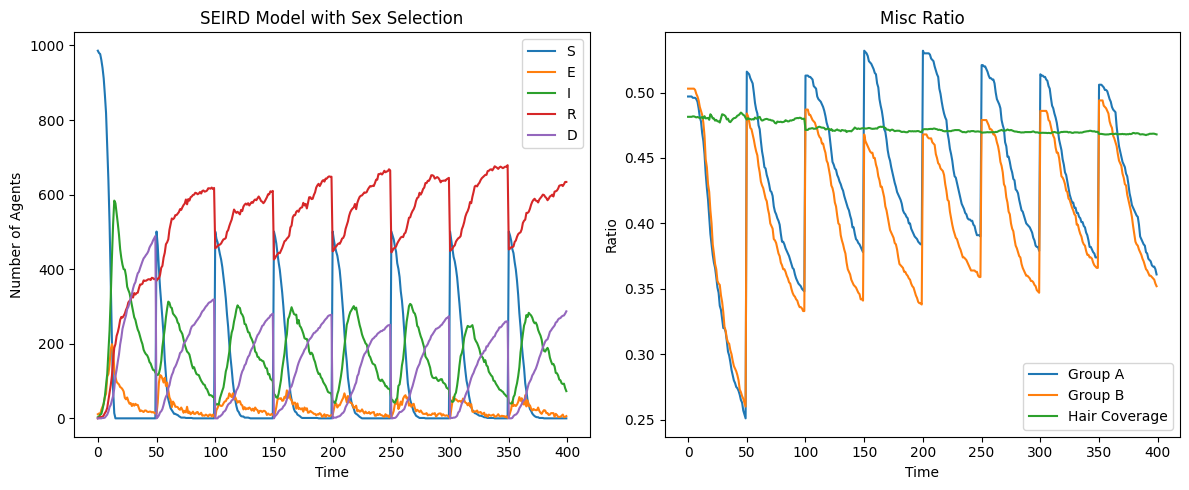

In [2]:
sim = VirusSimulation(0.5)
sim.run()
sim.plot()


進化をハッキリさせるため毒性が強めになっていて死亡者が多いのが今回のパラメータの特徴である。感染・回復もわかりやすいようかなり多めにしている。

世代交代が 50 期ごとなので、そこで毎回切れ目がある。

では次にこれを 10 回繰り返して、平均潜伏期間などの推移を見よう。

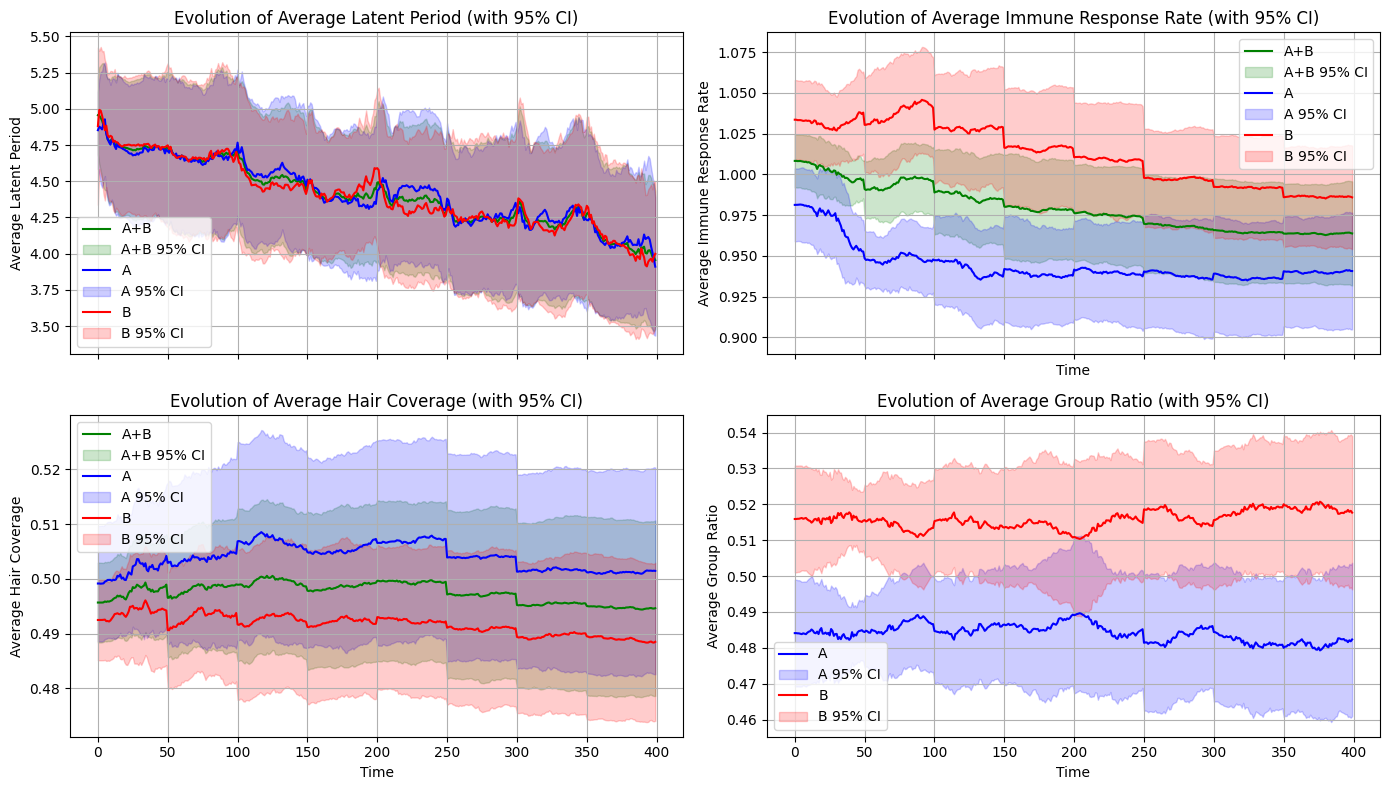

In [3]:
N_RUNS = 10

histories = run_experiments(n_runs=N_RUNS)
plot_experiments(histories)


さて LATENT_BETA が小さいので潜伏期間の短縮がちゃんと観測されている。ただし、A と B の違いがあっても潜伏期間の変化は変わらない。どうもローカルでいろいろやった結果、潜伏期間の短縮は単純に LATENT_BETA が小さいことが条件となるようだ。それはウィルスの進化だけで、人の進化は関係ない。

免疫応答速度が人の進化により変化している。ウィルス自体の潜伏期間は人の進化と関係なくても、人の免疫応答速度を考慮した「実効潜伏期間」は免疫応答速度が変化するため、変化する。今回は A B 共に下落傾向にあるようだ。病痕を評価する B グループのほうが、免疫応答速度は高めのはずで、そうなっている。なぜなら、潜伏期間中の回復には病痕はつかないため、実効潜伏期間が短いほうが B グループでは有利だからである。

体毛は、交配に使われる get_attractiveness をご覧になればわかる(と思う！)が、B グループでは体毛がマイナス評価になるため、体毛が減る進化圧が常にかかっており、確かに減っていっている。

体毛がないと発症時のコンタクトが制限される。そのため、体毛が少ない集団が固まっているなら、そこでの感染が少なくなるだろう。おそらくそのため B のほうが A より人口が多いのだろう。ただ、そこまで大差がついてるわけではない。

次の実験。

さて次の実験方針はこれを踏まえてかなり特殊な状況を設定しよう。まず、ウィルスの進化は人の進化に関連してはほとんど起きない。人の進化の結果をハッキリ見るために、ウィルスの進化は停止しよう。

LATENT_VIRULENCE を上げ RECOVERY_RATE を低いままにする。これまではよくある設定に似せて、潜伏期間中に死亡や回復が起きにくいとしていたが、それを変えてみる。ここまですると、潜伏期間があることのメリットは人間にはなくなる。すると実効潜伏期間を減らすよう免疫応答速度が増えるよう進化するはずだ。この設定は意外に思うかもしれないが、逆に発症後の毒性が低くなり、回復が増えるというのは、「対処療法」によると解釈すれば正当化できるだろう。

B グループの体毛の評価減もなくそう。体毛の評価減がコンタクト数に影響していて、病痕の影響がハッキリしなかったので、あえてこれをなくしてみる。

異種族間のコンタクトも交配も停止しよう。純粋にその種族の戦略が有利かだけを見るようにする。

信頼区間があまりにも大きいので、これを小さくするため、シミュレーション回数も増やそう。

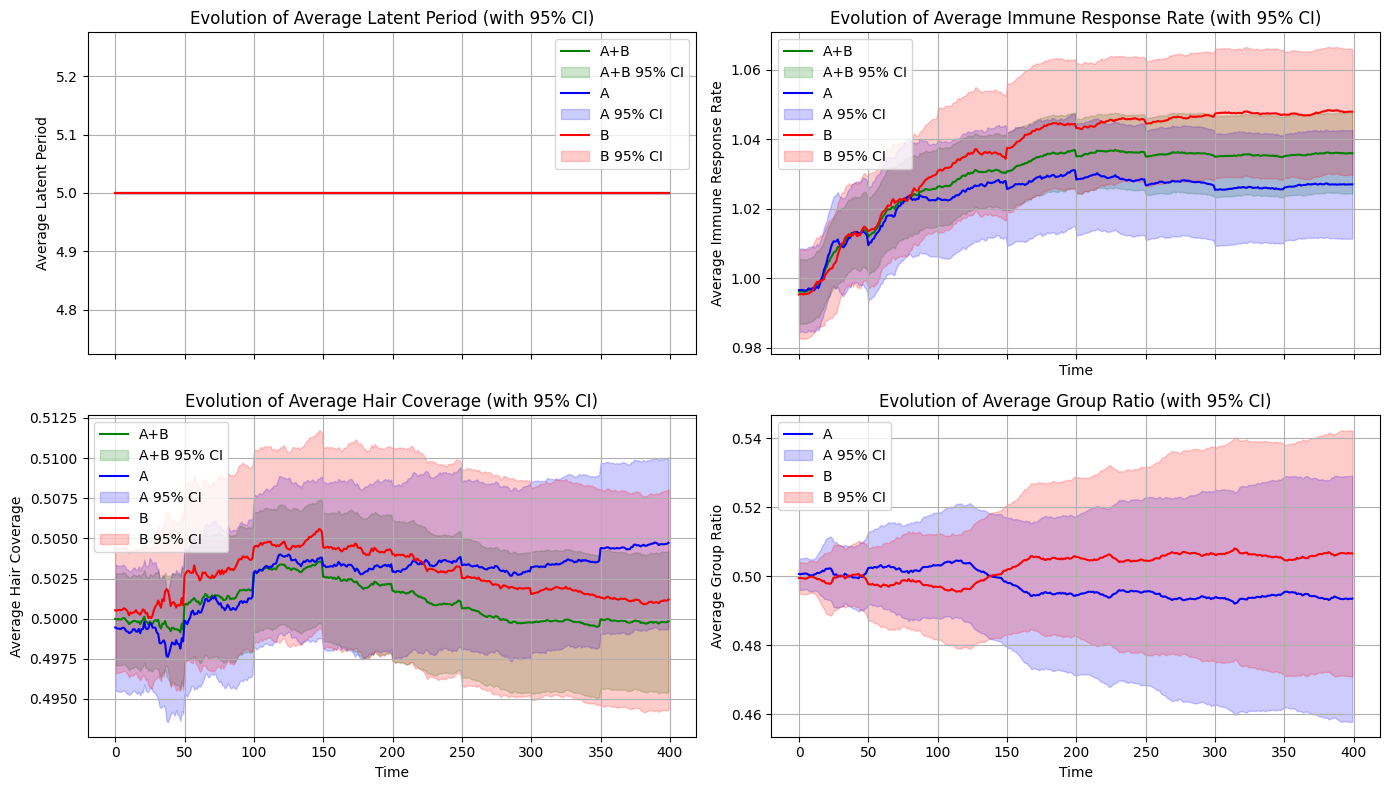

In [4]:
N_RUNS = 50   # 信頼区間生成のためのシミュレーションの繰り返し回数

LATENT_PERIOD_STD = 0.0   # 潜伏期間の初期分散 (0.0 は分散なし)
LATENT_MUTATION_WIDTH = 0.0   # 潜伏期間の進化的変化幅 (0.0 は変化なし)
B_HAIR_UNATTRACTIVE = False   # 病痕評価者は「体毛」に嫌うか？
INTERRACIAL_CONTACT = 0.0   # 異種族間のコンタクト強度 (0.0 は接触なし)
INTERRACIAL_MATING = 0.0   # 異種族間の交配強度 (0.0 は交配なし)

LATENT_VIRULENCE = VIRULENCE * 1.5   # 潜伏期間の毒性
LATENT_RECOVERY_RATE = RECOVERY_RATE * 0.5   # 潜伏期間の回復力

histories = run_experiments(n_runs=N_RUNS)
plot_experiments(histories)


体毛の変化はほぼランダムなのだろう。B の集団が増えているが信頼区間を考えるとそれほどハッキリしない。免疫応答速度は増加しているのは予想通りで、B のほうが免疫応答速度が増えるはずだという予想もだいたいそうなっている。信頼区間も考えるとハッキリとまではいえないかもしれないが。

次の実験。

人の進化はウィルスの進化にまったく影響しないのだろうか？

人の体毛が少なくなるように進化すれば、コンタクト数は減る。つまり、これは潜伏期間より発症後の感染力が減ることに相当するので、上の論理に従えば、潜伏期間は長くなるはずである。感染が少ない分 B のほうが増えることもハッキリ示せるかもしれない。

これを実験するために、潜伏期間の毒性は直上のままだが、ウィルスの潜伏期間を変化させるように戻そう。体毛による魅力減を復活させよう。人の進化には時間がかかるので期間も延長しよう。結果をハッキリさせるため、種族間のコンタクトと交配は停止したまま。

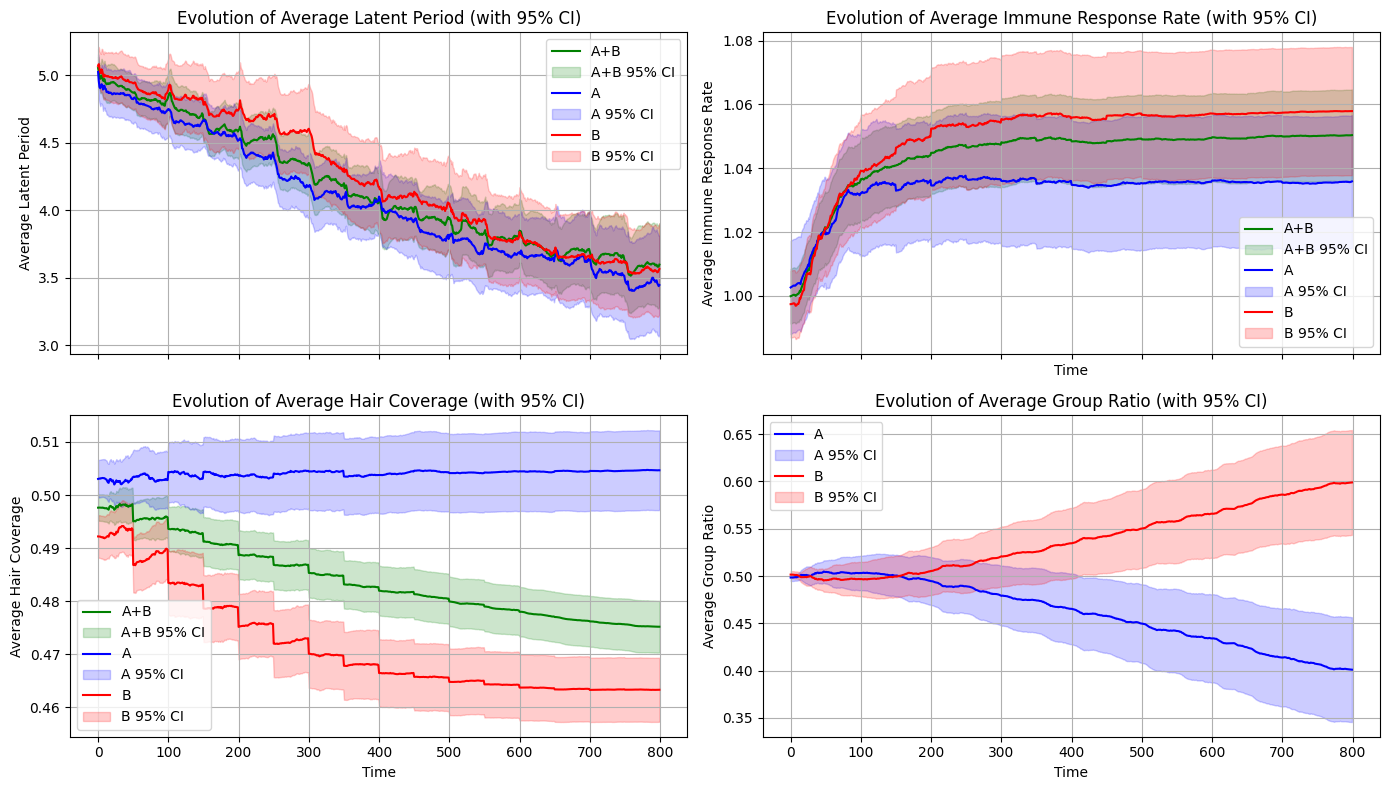

In [5]:
N_RUNS = 50   # 信頼区間生成のためのシミュレーションの繰り返し回数

T = 800    # 期間
LATENT_PERIOD_STD = 1.0   # 潜伏期間の初期分散
LATENT_MUTATION_WIDTH = 0.1   # 潜伏期間の進化的変化幅
B_HAIR_UNATTRACTIVE = True   # 病痕評価者は「体毛」に嫌うか？ True:嫌う
INTERRACIAL_CONTACT = 0.0   # 異種族間のコンタクト強度 (0.0 は接触なし)
INTERRACIAL_MATING = 0.0   # 異種族間の交配強度 (0.0 は交配なし)

LATENT_VIRULENCE = VIRULENCE * 1.5   # 潜伏期間の毒性
LATENT_RECOVERY_RATE = RECOVERY_RATE * 0.5   # 潜伏期間の回復力

histories = run_experiments(n_runs=N_RUNS)
plot_experiments(histories)


どうも B のほうがウィルスの潜伏期間が長くなるというのはほぼ観測できなかった。やはり人の進化はウィルスの進化にほぼ影響しないのだろう。

一方、B のほうが人口が多いのはハッキリしている。これは、体毛が少ないことによる感染減が、長期に続いたことで、データがハッキリしたのだろう。B のほうが免疫応答速度が大きいのもややハッキリさが減じたが示されている。ハッキリさが減じたのは、ウィルス自身の潜伏期間のランダムさが影響しているのかもしれない。

体毛の進化は予想通り。

次の実験。

共進化のようすを示すことはできなかったが、ただ、体毛が少なく十分進化した状況というのを設定して、そこで潜伏期間の短縮が起きるのかを見るということ自体はできる。

それには基本的には前回の↓のシミュレーションを使えばよい。それをほぼ再録しよう。ただし、二つのプロットを比較できるように変えてある。

https://gist.github.com/JRF-2018/42d292c92325bce1c515d229fe9486b5

## サブ実験のコード


In [6]:
import matplotlib.pyplot as plt
from scipy.stats import sem

N = 1000
T = 200
runs = 100

# シミュレーション補助関数
def calc_risk_0(states, virulence, infectivity, latent_period,
                max_latent, risk_mag):
    return 0

def calc_risk_1(states, virulence, infectivity, latent_period,
                max_latent, risk_mag):
    infected = (states == 'I')
    avg_virulence_t = virulence[infected].mean() \
        if infected.sum() > 0 else 0
    avg_infectivity_t = infectivity[infected].mean()\
        if infected.sum() > 0 else 0
    avg_latent_t = latent_period[infected].mean()\
        if infected.sum() > 0 else 0
    risk = min(avg_virulence_t, avg_infectivity_t,
               avg_latent_t / max_latent) * risk_mag
    return risk

# シミュレーション関数
def run_simulation(seed, N=N, initial_infected=10, T=T, base_contact_rate=5,
                   recovery_rate=0.1, virulence_mean=0.5, virulence_std=0.2,
                   infectivity_mean=0.3, infectivity_std=0.1, latent_mean=5.0,
                   latent_std=2.0, mutation_std=0.05, latent_mutation_std=0.2,

                   max_latent = 10,
                   latent_infectivity_mag = 0.3,
                   latent_mutation_mean = -0.3,
                   latent_threshold = 2,
                   isolation_mag = 2,
                   infection_effect = 2.5,
                   death_mag = 0.2,
                   risk_mag = 1.5, calc_risk = calc_risk_1,
                   ):
    np.random.seed(seed)

    # 初期化
    states = np.array(['S'] * N)
    # S：感受性(未感染)、I：感染、R：回復、D：死亡、Q：隔離
    states[:initial_infected] = 'E'
    virulence = np.zeros(N)
    infectivity = np.zeros(N)
    latent_period = np.zeros(N)
    latent_time = np.zeros(N)
    for i in range(initial_infected):
        virulence[i] = np.clip(np.random.normal(virulence_mean,
                                                virulence_std), 0, 1)
        infectivity[i] = np.clip(np.random.normal(infectivity_mean,
                                                  infectivity_std), 0, 1)
        latent_period[i] = np.clip(np.random.normal(latent_mean,
                                                    latent_std), 1, 10)

    # 記録
    S_count = [N - initial_infected]
    E_count = [initial_infected]
    I_count = [0]
    R_count = [0]
    D_count = [0]
    Q_count = [0]
    RF_count = [0]
    avg_virulence = [virulence[:initial_infected].mean()]
    avg_infectivity = [infectivity[:initial_infected].mean()]
    avg_latent = [latent_period[:initial_infected].mean() / max_latent]

    # シミュレーション
    for t in range(T):
        new_states = states.copy()
        new_virulence = virulence.copy()
        new_infectivity = infectivity.copy()
        new_latent_period = latent_period.copy()
        latent_time = latent_time + (states == 'E')

        # 平均毒性、感染力、潜伏期間に基づくコンタクト制限
        risk = calc_risk(states, virulence, infectivity, latent_period,
                         max_latent, risk_mag)
        restriction_factor = (1 - risk)**2 if risk < 1 else 0
        contact_rate = np.clip(int(base_contact_rate * restriction_factor),
                               1, int(base_contact_rate))

        # 潜伏感染者（E）
        for i in np.where(states == 'E')[0]:
            if latent_time[i] >= latent_period[i]:
                new_states[i] = 'I'
                latent_time[i] = 0
                continue
            if contact_rate > 0:
                contacts = np.random.choice(N, contact_rate, replace=False)
                for j in contacts:
                    if states[j] == 'S' \
                       and np.random.random() \
                       < infectivity[i] * latent_infectivity_mag:
                        new_states[j] = 'E'
                        new_virulence[j] = np.clip(
                            virulence[i] + np.random.normal(0, mutation_std),
                            0, 1
                        )
                        new_infectivity[j] = np.clip(
                            infectivity[i] + np.random.normal(0, mutation_std),
                            0, 1
                        )
                        new_latent_period[j] = np.clip(
                            latent_period[i]
                            + np.random.normal(latent_mutation_mean,
                                               latent_mutation_std),
                            1, max_latent
                        )

        # 症状あり感染者（I）
        infected = (states == 'I')
        avg_latent_t = latent_period[infected].mean() \
            if infected.sum() > 0 else 0
        for i in np.where(states == 'I')[0]:
            if np.random.random() < virulence[i]**isolation_mag:
                new_states[i] = 'Q'
                continue
            if np.random.random() < recovery_rate:
                new_states[i] = 'R'
                continue
            if np.random.random() < virulence[i] * death_mag:
                new_states[i] = 'D'
                continue

            # コンタクト数が、咳などで増えたり、裸で見えやすくて減ったりする。
            effective_contact_rate = int(contact_rate * infection_effect) \
                if contact_rate > 0 else 1
            contacts = np.random.choice(N, effective_contact_rate,
                                        replace=False)
            for j in contacts:
                if states[j] == 'S' and np.random.random() < infectivity[i]:
                    new_states[j] = 'E'
                    new_virulence[j] = np.clip(
                        virulence[i] + np.random.normal(0, mutation_std),
                        0, 1
                    )
                    new_infectivity[j] = np.clip(
                        infectivity[i] + np.random.normal(0, mutation_std),
                        0, 1
                    )
                    new_latent_period[j] = np.clip(
                        latent_period[i]
                        + np.random.normal(latent_mutation_mean,
                                           latent_mutation_std),
                        1, max_latent
                    )

        # 隔離状態（Q）
        for i in np.where(states == 'Q')[0]:
            if np.random.random() < recovery_rate:
                new_states[i] = 'R'
                continue
            if np.random.random() < virulence[i] * death_mag:
                new_states[i] = 'D'
                continue

        states = new_states
        virulence = new_virulence
        infectivity = new_infectivity
        latent_period = new_latent_period

        S_count.append(np.sum(states == 'S'))
        E_count.append(np.sum(states == 'E'))
        I_count.append(np.sum(states == 'I'))
        R_count.append(np.sum(states == 'R'))
        D_count.append(np.sum(states == 'D'))
        Q_count.append(np.sum(states == 'Q'))
        RF_count.append(restriction_factor)
        infected = (states == 'E') | (states == 'I') | (states == 'Q')
        avg_virulence.append(virulence[infected].mean()
                             if infected.sum() > 0 else np.nan)
        avg_infectivity.append(infectivity[infected].mean()
                               if infected.sum() > 0 else np.nan)
        avg_latent.append(latent_period[infected].mean() / max_latent
                          if infected.sum() > 0 else np.nan)

    return S_count, E_count, I_count, R_count, D_count, Q_count,\
        RF_count, avg_virulence, avg_infectivity, avg_latent



# 複数シミュレーション
def plot_simulation(run_simulation1, run_simulation2,
                    base="plt", runs=runs, N=N, T=T):
    all_S, all_E, all_I, all_R, all_D, all_Q = [], [], [], [], [], []
    all_virulence, all_infectivity, all_latent = [], [], []
    all_IEQ, all_RF = [], []
    for i in range(runs):
        S_count, E_count, I_count, R_count, D_count, Q_count, \
            RF_count, avg_virulence, avg_infectivity, avg_latent\
            = run_simulation1(seed=i, N=N, T=T)
        all_S.append(S_count)
        all_E.append(E_count)
        all_I.append(I_count)
        all_R.append(R_count)
        all_D.append(D_count)
        all_Q.append(Q_count)
        all_RF.append(RF_count)
        IEQ_count = [(i + e + q) / N for i,e,q
                     in zip(I_count, E_count, Q_count)]
        all_IEQ.append(IEQ_count)
        all_virulence.append(avg_virulence)
        all_infectivity.append(avg_infectivity)
        all_latent.append(avg_latent)

    # 平均と信頼区間
    mean_virulence = np.nanmean(all_virulence, axis=0)
    se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
    mean_infectivity = np.nanmean(all_infectivity, axis=0)
    se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
    mean_latent = np.nanmean(all_latent, axis=0)
    se_latent = sem(all_latent, axis=0, nan_policy='omit')
    mean_IEQ = np.nanmean(all_IEQ, axis=0)
    se_IEQ = sem(all_IEQ, axis=0, nan_policy='omit')
    mean_RF = np.nanmean(all_RF, axis=0)
    se_RF = sem(all_RF, axis=0, nan_policy='omit')

    # グラフ描画
    plt.figure(figsize=(12, 8))

    # 平均特性（信頼区間付き）
    plt.plot(mean_virulence, label='1 Average Virulence', color='red')
    plt.fill_between(range(T+1), mean_virulence - 1.96*se_virulence,
                     mean_virulence + 1.96*se_virulence, color='red',
                     alpha=0.2)
    plt.plot(mean_infectivity, label='1 Average Infectivity', color='green')
    plt.fill_between(range(T+1), mean_infectivity - 1.96*se_infectivity,
                     mean_infectivity + 1.96*se_infectivity, color='green',
                     alpha=0.2)
    plt.plot(mean_latent, label='1 Average Latent Period', color='blue')
    plt.fill_between(range(T+1), mean_latent - 1.96*se_latent,
                     mean_latent + 1.96*se_latent, color='blue', alpha=0.2)

    all_S, all_E, all_I, all_R, all_D, all_Q = [], [], [], [], [], []
    all_virulence, all_infectivity, all_latent = [], [], []
    all_IEQ, all_RF = [], []
    for i in range(runs):
        S_count, E_count, I_count, R_count, D_count, Q_count, \
            RF_count, avg_virulence, avg_infectivity, avg_latent\
            = run_simulation2(seed=i, N=N, T=T)
        all_S.append(S_count)
        all_E.append(E_count)
        all_I.append(I_count)
        all_R.append(R_count)
        all_D.append(D_count)
        all_Q.append(Q_count)
        all_RF.append(RF_count)
        IEQ_count = [(i + e + q) / N for i,e,q
                     in zip(I_count, E_count, Q_count)]
        all_IEQ.append(IEQ_count)
        all_virulence.append(avg_virulence)
        all_infectivity.append(avg_infectivity)
        all_latent.append(avg_latent)

    # 平均と信頼区間
    mean_virulence = np.nanmean(all_virulence, axis=0)
    se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
    mean_infectivity = np.nanmean(all_infectivity, axis=0)
    se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
    mean_latent = np.nanmean(all_latent, axis=0)
    se_latent = sem(all_latent, axis=0, nan_policy='omit')
    mean_IEQ = np.nanmean(all_IEQ, axis=0)
    se_IEQ = sem(all_IEQ, axis=0, nan_policy='omit')
    mean_RF = np.nanmean(all_RF, axis=0)
    se_RF = sem(all_RF, axis=0, nan_policy='omit')

    # 平均特性（信頼区間付き）
    plt.plot(mean_virulence, label='2 Average Virulence', color='orange')
    plt.fill_between(range(T+1), mean_virulence - 1.96*se_virulence,
                     mean_virulence + 1.96*se_virulence, color='orange',
                     alpha=0.2)
    plt.plot(mean_infectivity, label='2 Average Infectivity', color='yellow')
    plt.fill_between(range(T+1), mean_infectivity - 1.96*se_infectivity,
                     mean_infectivity + 1.96*se_infectivity, color='yellow',
                     alpha=0.2)
    plt.plot(mean_latent, label='2 Average Latent Period', color='cyan')
    plt.fill_between(range(T+1), mean_latent - 1.96*se_latent,
                     mean_latent + 1.96*se_latent, color='cyan', alpha=0.2)

    plt.xlabel('Time (days)')
    plt.ylabel('Value')
    plt.title('Evolution of Virulence, Infectivity, and Latent Period'
              + ' (Mean ± 95% CI)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(base + ".png")
    plt.show()


やりたい実験はこうである。

裸を是とする文化とそうでない咳を是とするような文化の差を調べ、裸を是とする文化では、潜伏期間が長くなりがちなことを示したい。そのため、裸を是とする文化は症状が発見されやすく避けられがちなため、発症後のコンタクト数の係数である infection_effect を小さめに設定し、逆に咳を是とする文化ではそれを大きめに設定する。わかりやすくするため、その差を極端にする。

ではまずはロックダウン政策がない状況でやってみよう。

<ipython-input-6-6f015b11b413>:211: RuntimeWarning: Mean of empty slice
  mean_virulence = np.nanmean(all_virulence, axis=0)
<ipython-input-6-6f015b11b413>:212: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
<ipython-input-6-6f015b11b413>:213: RuntimeWarning: Mean of empty slice
  mean_infectivity = np.nanmean(all_infectivity, axis=0)
<ipython-input-6-6f015b11b413>:214: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
<ipython-input-6-6f015b11b413>:215: RuntimeWarning: Mean of empty slice
  mean_latent = np.nanmean(all_latent, axis=

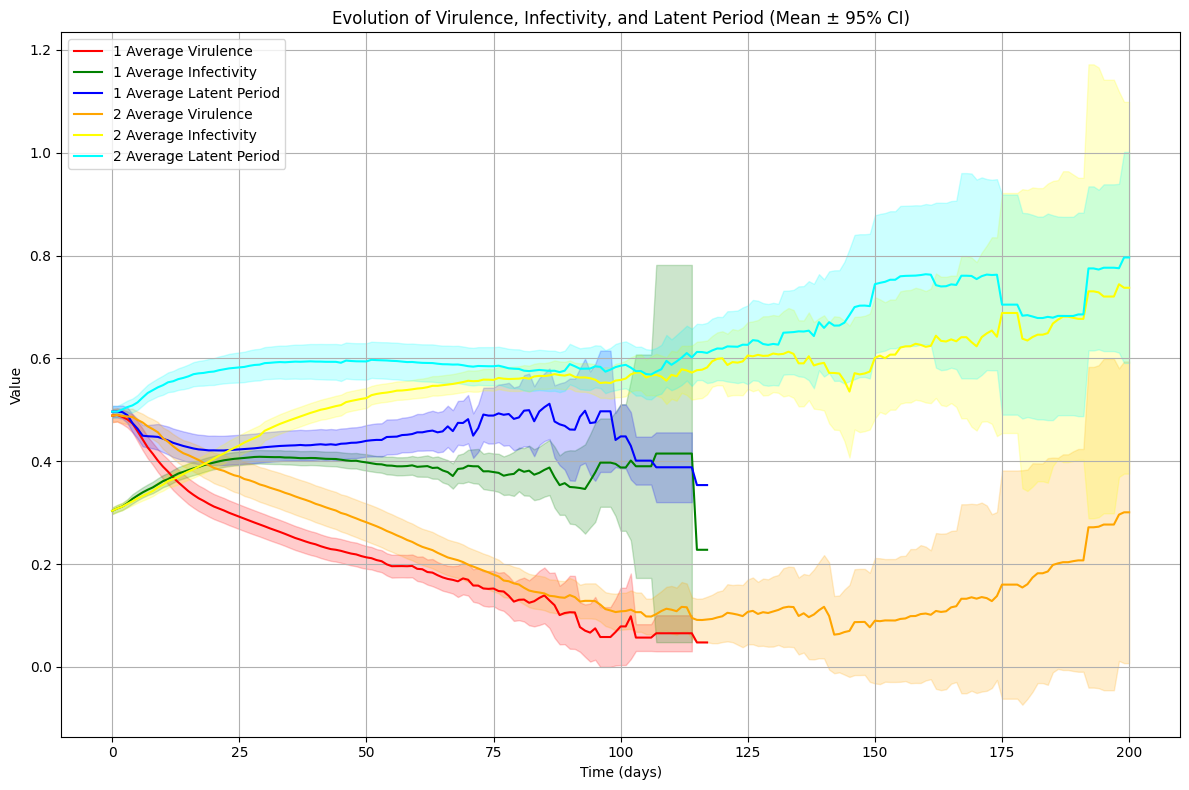

In [7]:
plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.1,
                               latent_mutation_mean = 0.0,
                               latent_threshold = 2,
                               isolation_mag = 1.0,
                               infection_effect = 2.5,
                               risk_mag = 1.0, calc_risk = calc_risk_0),
                lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.1,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 0.5,
                               risk_mag = 1.0, calc_risk = calc_risk_0),
                base="plt-9-0")


潜伏期間は裸でコンタクト数が制限されるのがシアン色、咳などでコンタクト数が増えるのが青色。予想通り、裸を是とするシアン色のほうが長い。現代も感染を制限しがちなので、潜伏期間という面からすると、長く＝悪化する方向に圧力をかけていることになるだろう。コンタクト数の制限が逆にウィルスの感染力を高める方向に進化を促しているらしいことも読み取れる。逆にユニバーサル・マスクを解除するという政策は、ウィルス進化の面から見れば、人類にとって都合が良い面があるともいえそうだ。

次にロックダウンがある状況でもためしてみよう。

<ipython-input-6-6f015b11b413>:212: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
<ipython-input-6-6f015b11b413>:214: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
<ipython-input-6-6f015b11b413>:216: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_latent = sem(all_latent, axis=0, nan_policy='omit')


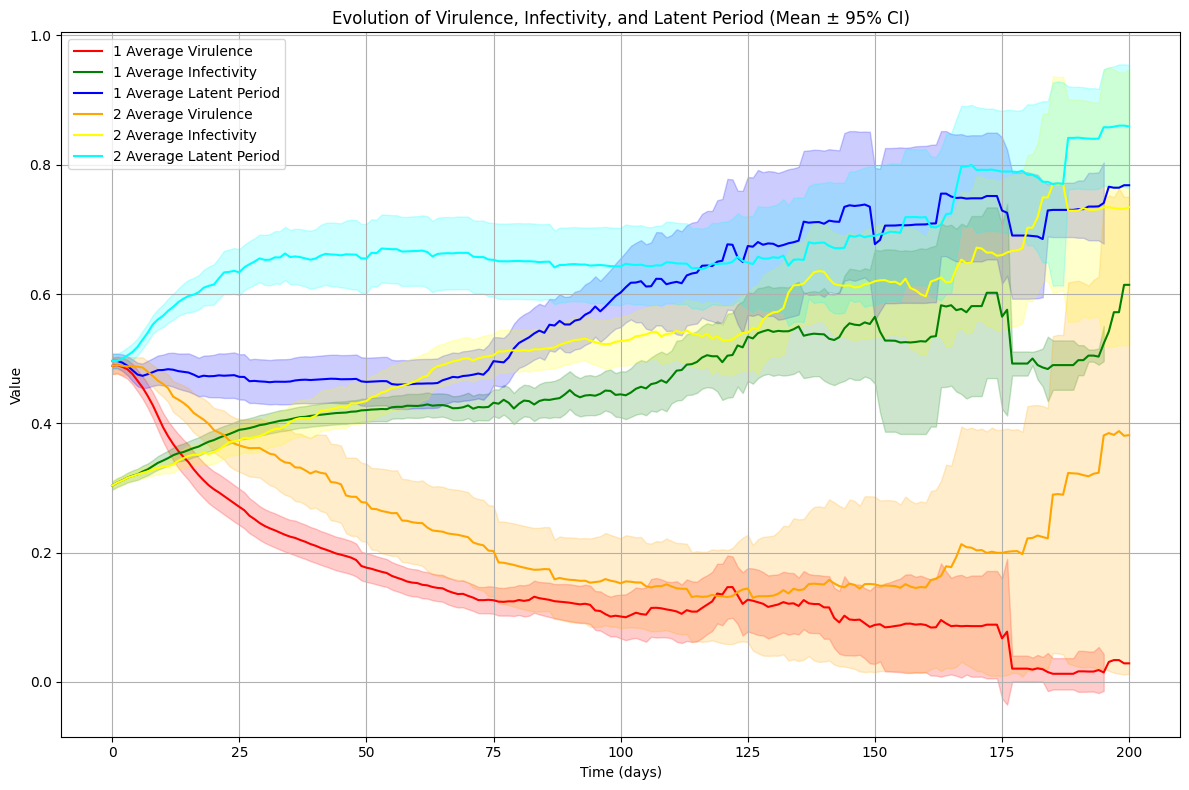

In [8]:
plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.1,
                               latent_mutation_mean = 0.0,
                               latent_threshold = 2,
                               isolation_mag = 1.0,
                               infection_effect = 2.5,
                               risk_mag = 1.0, calc_risk = calc_risk_1),
                lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.1,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 0.5,
                               risk_mag = 1.0, calc_risk = calc_risk_1),
                base="plt-9-1")


やはりロックダウン下でも裸を是とする文化の潜伏期間は長くなる。

実はロックダウンは潜伏期間の短縮にはマイナスのようだ。コンタクトの少ない状況で、ロックダウンありなしで比較してみよう。

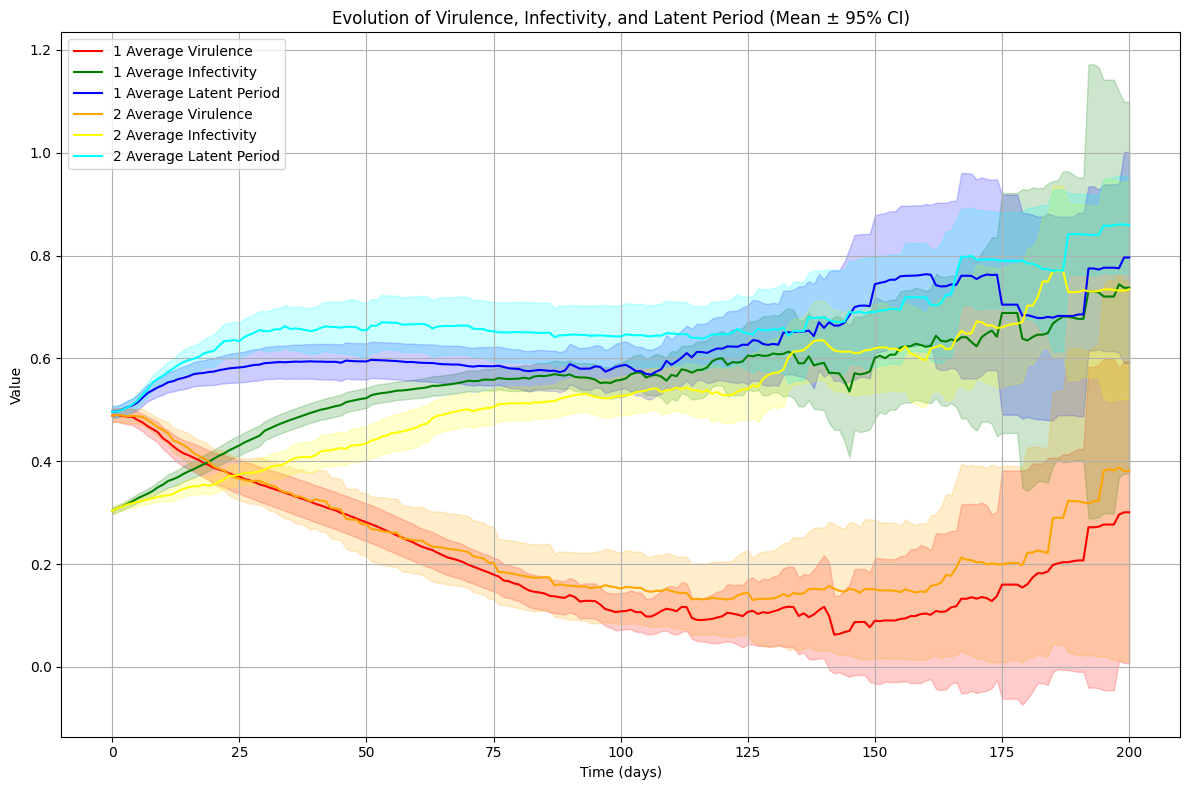

In [9]:
plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.1,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 0.5,
                               risk_mag = 1.0, calc_risk = calc_risk_0),
                lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.1,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 0.5,
                               risk_mag = 1.0, calc_risk = calc_risk_1),
                base="plt-9-2")


ロックダウンをしているのがシアン色、していないのが青色で、するほうが潜伏期間は長くなる。これは感染させない方向の変化だからそうなるのは、これまでからいって当然なのかもしれない。もちろん、前回見たようにロックダウンをすることで感染者の山をなだらかにし、その間に対策を打てるという側面はあるのだが。


## 結論

病痕を評価する文化が、実効潜伏期間を短縮することはおそらく言えた。信頼区間的にハッキリとまでは言えないが。…といったところ。

ウィルス自体の潜伏期間を減らすのに潜伏期間と発症後の感染確率(感染力)の差が大きなファクターであることはわかった。マスク解除のような政策が、潜伏期間や感染力を悪化させない面はあるのかもしれない。

ウィルスと人類の共進化シミュレーションを目指したが、そこまではできず、ちょっとお茶をにごした面はある。
